In [1]:
import numpy as np
import matplotlib.pyplot as plt

from rvseg import patient, model, loss
from rvseg import dataset

%matplotlib inline

Using TensorFlow backend.


# Dice and Jaccard

In [2]:
def sorensen_dice(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return 2*intersection / (np.sum(y_true) + np.sum(y_pred))

def jaccard(y_true, y_pred):
    intersection = np.sum(y_true & y_pred)
    union = np.sum(y_true | y_pred)
    return intersection / union

In [3]:
# load saved model weights
m = model.u_net(height=216, width=256, maps=1,
                features=32, depth=3, classes=2,
                temperature=1.0,
                padding='same', batchnorm=False)
m.load_weights("../results/elastic-augmentation/2-dice/weights-483-0.8022.hdf5")

# Train and Validation Performance

In [4]:
# load validation data
data_dir = "/home/paperspace/Developer/datasets/RVSC/TrainingSet/"
batch_size = 32
validation_split = 0.2

train_generator, train_steps_per_epoch, \
    val_generator, val_steps_per_epoch = dataset.create_generators(
        data_dir, batch_size, validation_split)

In [5]:
avg_dice = avg_jaccard = 0
samples = 0
for i in range(train_steps_per_epoch):
    images, masks_true = next(train_generator)
    masks_pred = m.predict(images)
    for mask_true, mask_pred in zip(masks_true, masks_pred):
        y_true = mask_true[:,:,1].astype('uint8')
        y_pred = np.round(mask_pred[:,:,1]).astype('uint8')
        avg_dice += sorensen_dice(y_true, y_pred)
        avg_jaccard += jaccard(y_true, y_pred)
        samples += 1
print(avg_dice / samples, avg_jaccard / samples)

0.784021897216 0.658461944423


In [6]:
avg_dice = avg_jaccard = 0
samples = 0
for i in range(val_steps_per_epoch):
    images, masks_true = next(val_generator)
    masks_pred = m.predict(images)
    for mask_true, mask_pred in zip(masks_true, masks_pred):
        y_true = mask_true[:,:,1].astype('uint8')
        y_pred = np.round(mask_pred[:,:,1]).astype('uint8')
        avg_dice += sorensen_dice(y_true, y_pred)
        avg_jaccard += jaccard(y_true, y_pred)
        samples += 1
print(avg_dice / samples, avg_jaccard / samples)

0.668854210081 0.538351020752


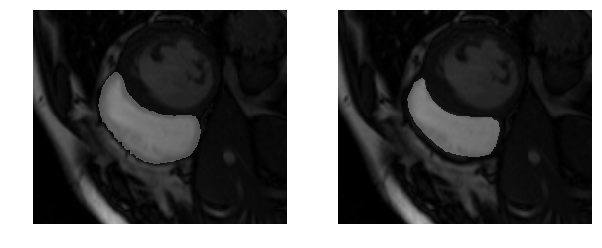

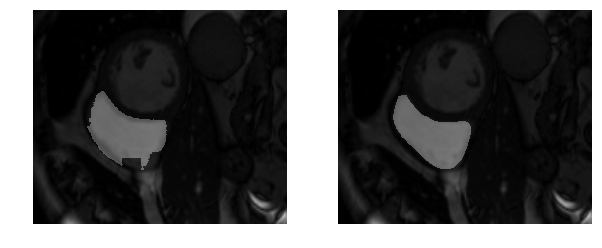

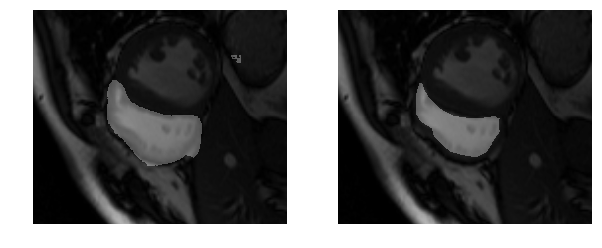

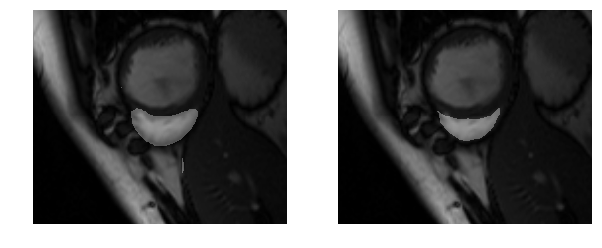

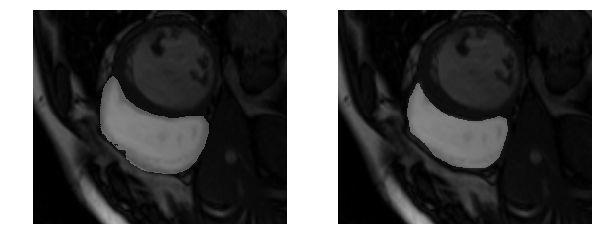

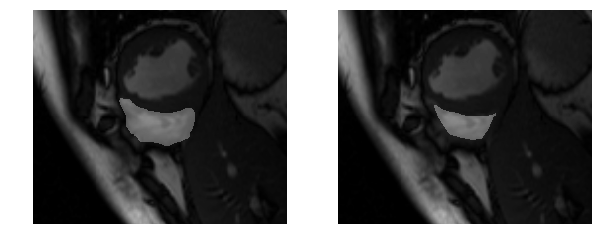

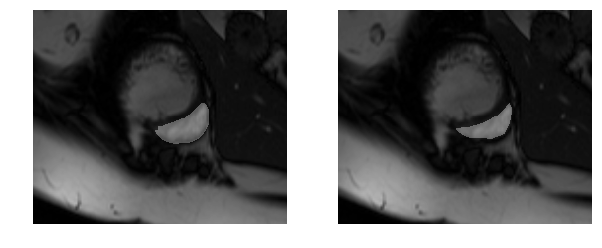

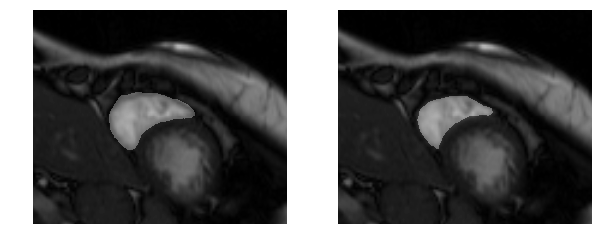

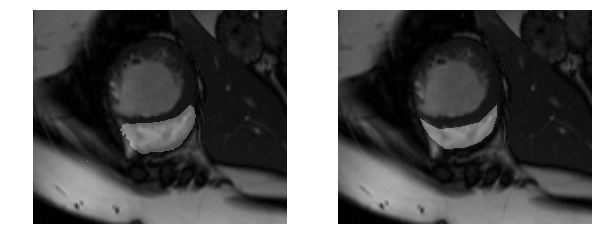

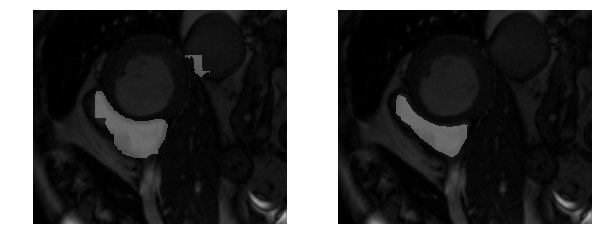

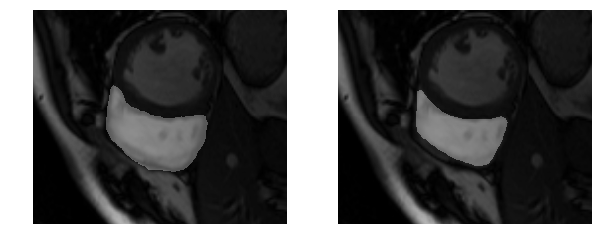

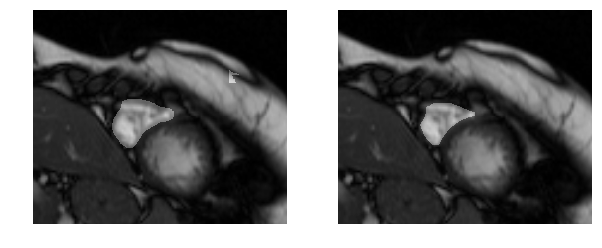

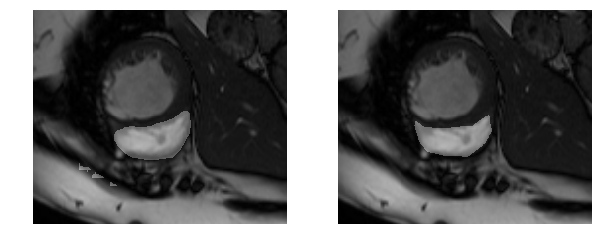

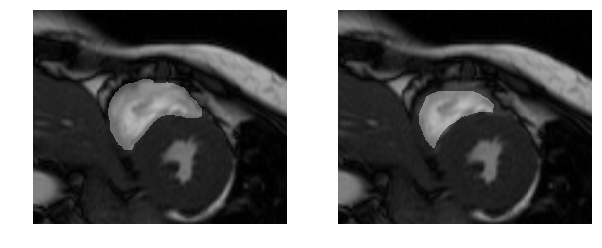

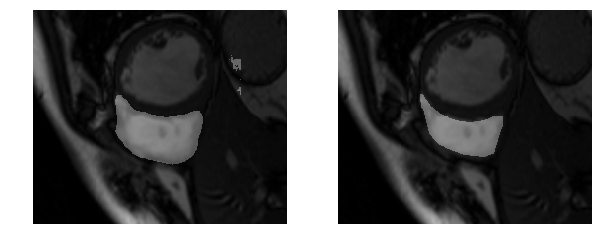

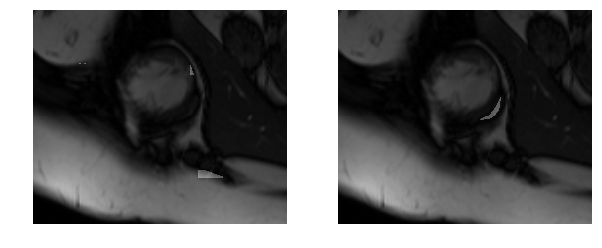

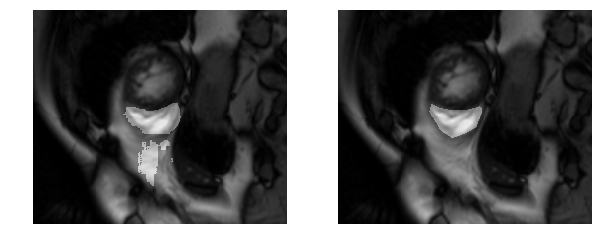

In [7]:
i = 0
for mask_true, mask_pred, image in zip(masks_true, masks_pred, images):
    plt.figure(figsize=(10,25))
    plt.subplot(1, 2, 1)
    plt.axis("off")
    plt.imshow(image[:,:,0], cmap=plt.cm.gray)
    plt.imshow(np.round(mask_pred[:,:,1]), cmap=plt.cm.gray, alpha=0.3)
    plt.subplot(1, 2, 2)
    plt.axis("off")
    plt.imshow(image[:,:,0], cmap=plt.cm.gray)
    plt.imshow(mask_true[:,:,1], cmap=plt.cm.gray, alpha=0.3)
    # plt.savefig("{:02d}.png".format(i), bbox_inches='tight')
    i += 1

# Peek at Test Data

In [21]:
# load test data

data_dir = "/home/paperspace/Developer/datasets/RVSC/Test1Set/patient17/"
p = patient.PatientData(data_dir)
images = np.asarray(p.all_images)[:,:,:,None]

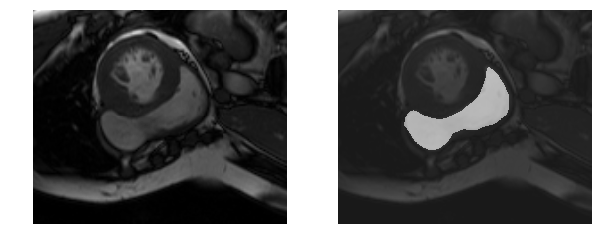

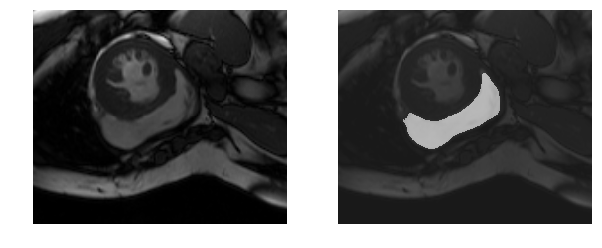

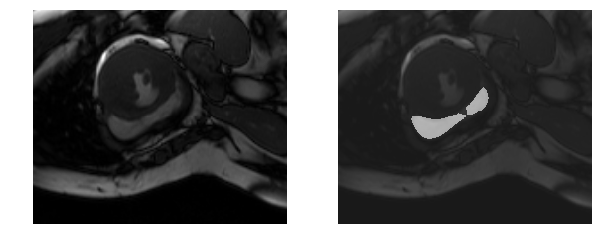

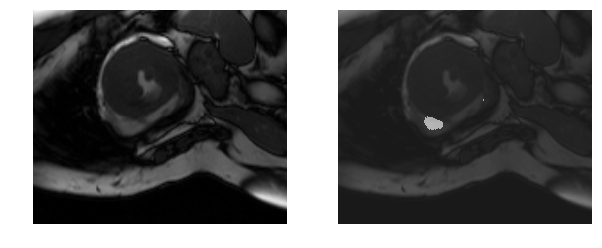

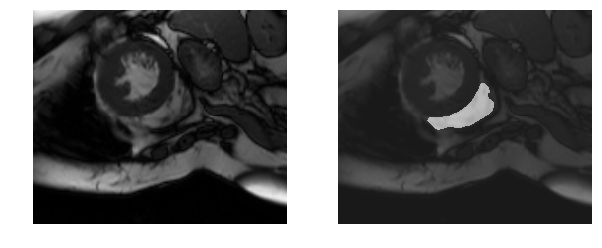

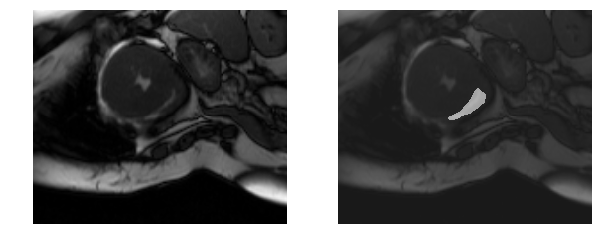

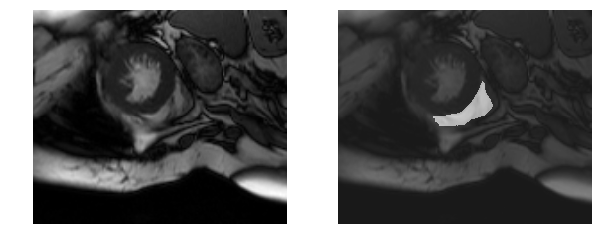

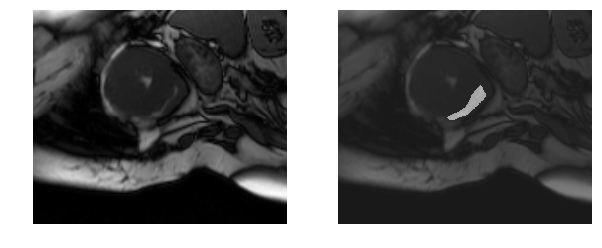

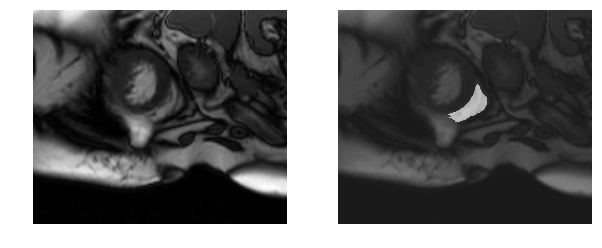

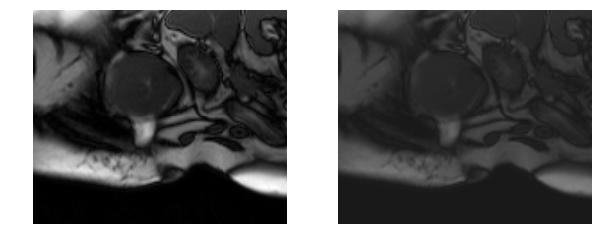

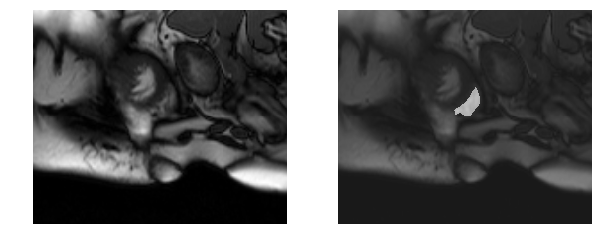

In [23]:
masks = m.predict(images)

n = 80
for n in [80, 100, 108, 128, 140, 148, 160, 168, 180, 188, 200]:
    plt.figure(figsize=(10,25))
    plt.subplot(1, 2, 1)
    plt.axis("off")
    plt.imshow(p.all_images[n], cmap=plt.cm.gray)
    plt.subplot(1, 2, 2)
    plt.axis("off")
    plt.imshow(p.all_images[n], cmap=plt.cm.gray, alpha=0.8)
    plt.imshow(np.round(masks[n,:,:,1]), cmap=plt.cm.gray, alpha=0.5)